## CASSDA - Data Download

Contains code to download the following data
- Wildlife crossings from OSM
- Streets from OSM
- High-Resolution satellite images from discomap https://discomap.eea.europa.eu/wiki/ (Cloudless 2m/px satellite data)

In [3]:
import sys
import os

sys.path.append("../src")

import requests as r
from shapely.geometry import LineString, MultiPolygon, Point, Polygon
import geopandas as gpd
from owslib.wms import WebMapService

from osm.queries import get_street_query, get_wildlife_crossing_query
from wms.get_wms_crops import get_crop_bboxes

#### Global Config

In [4]:
countries_to_process = ["CH"]
image_output_dir = "../data/satellite_images/"
geodata_output_dir = "../data/geodata/"

In [5]:
# these typically do not need to be changed
OVERPASS_API_URL = "https://overpass-api.de/api/interpreter"
WMS_URL = "https://image.discomap.eea.europa.eu/arcgis/services/GioLand/VHR_2021_LAEA/ImageServer/WMSServer/?request=GetCapabilities&service=WMS"
CRS = "EPSG:3035"  # ETRS89 / ETRS-LAEA
PIXEL_RESOLUTION_M = 2  # 2 meters per pixel

### Wildlife Crossing

#### Export Polygons from OSM

In [ ]:
# config for wildlife crossing query
bridges_only = True  # whether to only consider bridges or tunnels and other as well

Gets the queries according to defined parameters, sends it co Overpass-API and 
on success stores the result in <geodata_output_dir>

In [8]:
bridges_string = "_bridges_only" if bridges_only else ""

for country in countries_to_process:
    print(f"Processing country: {country}")

    # Download wildlife crossings
    crossing_query = get_wildlife_crossing_query(
        country, timeout=240, bridges_only=bridges_only
    )
    response = r.get(OVERPASS_API_URL, params={"data": crossing_query})
    response.raise_for_status()
    data = response.json()

    features = []
    for el in data["elements"]:
        tags = el.get("tags", {})

        # Node → Point
        if el["type"] == "node":
            geometry = Point(el["lon"], el["lat"])
            features.append({"id": el["id"], "geometry": geometry, **tags})

        # Way → LineString or Polygon
        elif el["type"] == "way" and "geometry" in el:
            coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
            if len(coords) >= 3 and coords[0] == coords[-1]:
                geometry = Polygon(coords)  # Closed → Polygon
            else:
                geometry = LineString(coords)  # Open → LineString
            features.append({"id": el["id"], "geometry": geometry, **tags})

        # Relation → MultiPolygon (if members have geometry)
        elif el["type"] == "relation" and "members" in el:
            polygons = []
            for member in el["members"]:
                if member["type"] == "way" and "geometry" in member:
                    coords = [(pt["lon"], pt["lat"]) for pt in member["geometry"]]
                    if len(coords) >= 3:
                        polygons.append(Polygon(coords))
            if polygons:
                geometry = MultiPolygon(polygons) if len(polygons) > 1 else polygons[0]
                features.append({"id": el["id"], "geometry": geometry, **tags})

    # --- Create GeoDataFrame ---
    if features:
        print(f"Found {len(features)} wildlife crossings.")
        gdf = gpd.GeoDataFrame(features, geometry="geometry", crs="EPSG:4326")
    else:
        print("No wildlife crossings found.")

    # --- Reproject to EPSG:3035 (ETRS89 / LAEA Europe) ---
    if not gdf.empty:
        gdf = gdf.to_crs(epsg=3035)
        print("Reprojected to EPSG:3035.")

    os.makedirs(geodata_output_dir, exist_ok=True)

    # Save the GeoDataFrame to a file
    output_file = os.path.join(
        geodata_output_dir,
        f"{country.lower()}_wildlife_crossings_osm{bridges_string}.geojson",
    )
    gdf.to_file(output_file, driver="GeoJSON")
    print(f"Saved GeoDataFrame to {output_file}")

Processing country: CH
Found 18 wildlife crossings.
Reprojected to EPSG:3035.
Saved GeoDataFrame to ../data/geodata/ch_wildlife_crossings_osm_bridges_only.geojson


### Download WMS Images

#### Function Definition

In [17]:
def polygon_to_yolo_segmentation(polygon, bbox, class_id=0):
    """
    Convert a polygon to YOLO segmentation format.
    
    YOLO segmentation format:
    <class_id> <x1> <y1> <x2> <y2> ... <xn> <yn>
    
    All coordinates are normalized (0-1 range) relative to the image dimensions.
    
    Parameters:
    -----------
    polygon : shapely.geometry.Polygon
        The polygon to convert
    bbox : tuple
        Bounding box (minx, miny, maxx, maxy) in the same CRS as polygon
    class_id : int
        Class ID for YOLO (default: 0)
    
    Returns:
    --------
    str
        YOLO format string for the polygon
    """
    minx, miny, maxx, maxy = bbox
    bbox_width = maxx - minx
    bbox_height = maxy - miny
    
    # Get exterior coordinates of the polygon
    if hasattr(polygon, 'exterior'):
        coords = list(polygon.exterior.coords)
    else:
        # Handle Point geometries by creating a small square around them
        if polygon.geom_type == 'Point':
            x, y = polygon.x, polygon.y
            # Create a small square (1% of bbox size)
            offset = min(bbox_width, bbox_height) * 0.01
            coords = [
                (x - offset, y - offset),
                (x + offset, y - offset),
                (x + offset, y + offset),
                (x - offset, y + offset),
                (x - offset, y - offset)
            ]
        else:
            return None
    
    # Convert coordinates to normalized YOLO format
    yolo_coords = []
    for x, y in coords[:-1]:  # Skip last point (same as first in closed polygon)
        # Normalize x coordinate (0 = left, 1 = right)
        norm_x = (x - minx) / bbox_width
        
        # Normalize y coordinate and FLIP for image coordinates
        # Geographic: y increases upward (miny at bottom, maxy at top)
        # Image: y increases downward (0 at top, 1 at bottom)
        # So we need: 1 - normalized_y
        norm_y = 1.0 - ((y - miny) / bbox_height)
        
        # Clamp to [0, 1] range
        norm_x = max(0.0, min(1.0, norm_x))
        norm_y = max(0.0, min(1.0, norm_y))
        
        yolo_coords.extend([norm_x, norm_y])
    
    # Format: class_id x1 y1 x2 y2 ... xn yn
    yolo_line = f"{class_id} " + " ".join([f"{coord:.6f}" for coord in yolo_coords])
    
    return yolo_line

#### Config

In [21]:
# config for satellite image download
pixel_size = 2  # meter per pixel
buffer_size = 512  # meter buffer around each point, square bbox

source_geometry_files = [
    "../data/geodata/combined_wildlife_poly_bridges_filtered.gpkg"
]

In [8]:
wms = WebMapService(
    WMS_URL,
    version="1.3.0",
)
layer_name = list(wms.contents)[0]
print(layer_name)

VHR_2021_LAEA


In [23]:
for f in source_geometry_files:
    print(f"Processing source geometry file: {os.path.basename(f)}")
    gdf = gpd.read_file(f)
    gdf = gdf[
        (gdf.geom_type == "Polygon")
        | (gdf.geom_type == "Point") & (gdf["bridge"] == "yes")
    ]
    print(f"Number of geometries to process: {len(gdf)}")

    gdf_centroids = gdf.to_crs(epsg=3035).centroid
    areas_of_interest = get_crop_bboxes(gdf_centroids, buffer_size)

    output_subdir = os.path.join(
        image_output_dir, os.path.splitext(os.path.basename(f))[0]
    )
    os.makedirs(output_subdir, exist_ok=True)
    os.makedirs(os.path.join(output_subdir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_subdir, "labels"), exist_ok=True)


    # for every point create a square around it and request a WMS crop centered on the point
    img_format = "image/png"
    img_size = (
        int(buffer_size * 2 / pixel_size),
        int(buffer_size * 2 / pixel_size),
    )  # width, height in pixels

    for idx, bbox in enumerate(areas_of_interest):
        # Request WMS image
        img = wms.getmap(
            layers=[layer_name],
            srs="EPSG:3035",
            bbox=bbox,
            size=img_size,
            format=img_format,
            transparent=True,
        )

        # Save image to file
        img_data = img.read()
        img_filename = os.path.join(output_subdir, "images", f"crossing_{idx}.png")
        with open(img_filename, "wb") as f:
            f.write(img_data)

        # save polygon label to file in yolo format
        label_filename = os.path.join(output_subdir, "labels", f"crossing_{idx}.txt")
        polygon = gdf.geometry.iloc[idx]
        
        # Convert polygon to YOLO segmentation format
        yolo_line = polygon_to_yolo_segmentation(
            polygon, bbox, class_id=0
        )
        
        if yolo_line:
            with open(label_filename, "w") as f:
                f.write(yolo_line + "\n")
            print(f"Saved WMS crop and label for crossing {idx} to {img_filename}")
        else:
            print(f"Warning: Could not convert geometry {idx} to YOLO format")

Processing source geometry file: combined_wildlife_poly_bridges_filtered.gpkg
Number of geometries to process: 480
Saved WMS crop and label for crossing 0 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_0.png
Saved WMS crop and label for crossing 1 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_1.png
Saved WMS crop and label for crossing 2 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_2.png
Saved WMS crop and label for crossing 3 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_3.png
Saved WMS crop and label for crossing 4 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_4.png
Saved WMS crop and label for crossing 5 to ../data/satellite_images/combined_wildlife_poly_bridges_filtered\images\crossing_5.png
Saved WMS crop and label for crossing 6 to ../data/satellite_images/combined_wildlife_poly_bridges_filter

### Visualize YOLO Labels (Optional)

Verify that the YOLO segmentation labels are correct by overlaying them on the images.

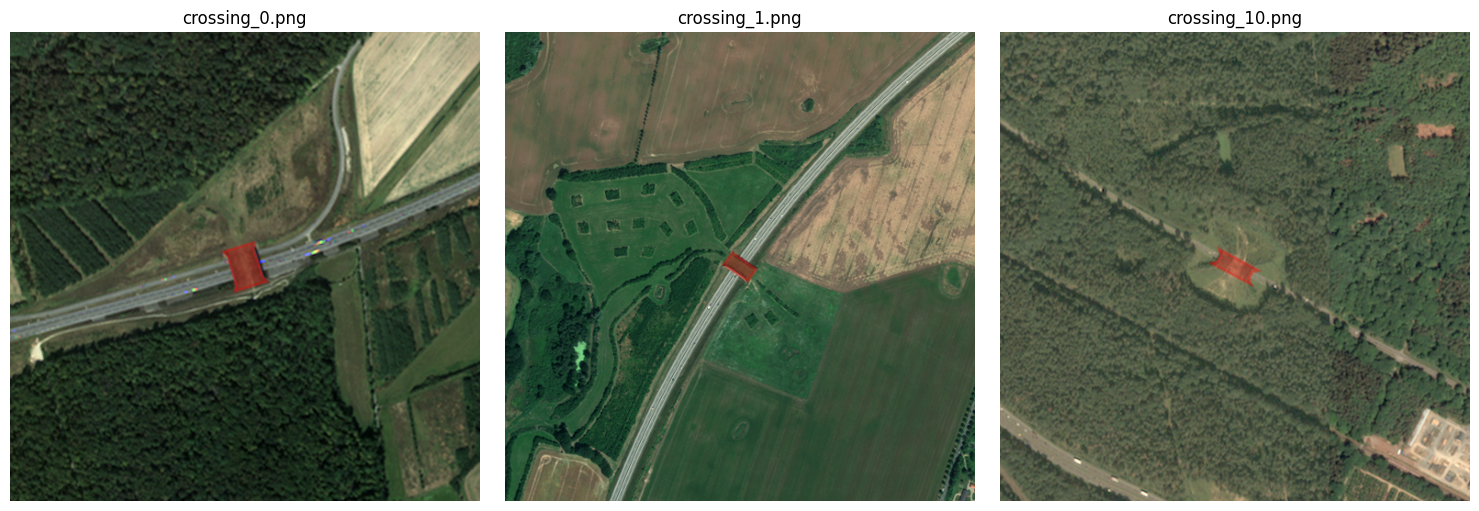

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def visualize_yolo_label(image_path, label_path, num_examples=3):
    """
    Visualize YOLO segmentation labels overlaid on images.
    
    Parameters:
    -----------
    image_path : str
        Path to the directory containing images
    label_path : str
        Path to the directory containing YOLO label files
    num_examples : int
        Number of examples to visualize
    """
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.png')])[:num_examples]
    
    fig, axes = plt.subplots(1, num_examples, figsize=(5*num_examples, 5))
    if num_examples == 1:
        axes = [axes]
    
    for idx, img_file in enumerate(image_files):
        # Load image
        img = Image.open(os.path.join(image_path, img_file))
        img_array = np.array(img)
        
        # Load corresponding label
        label_file = img_file.replace('.png', '.txt')
        label_file_path = os.path.join(label_path, label_file)
        
        ax = axes[idx]
        ax.imshow(img_array)
        
        # Read and parse YOLO label
        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 3:
                        continue
                    
                    class_id = int(parts[0])
                    coords = [float(x) for x in parts[1:]]
                    
                    # Convert normalized coordinates to pixel coordinates
                    img_height, img_width = img_array.shape[:2]
                    pixel_coords = []
                    for i in range(0, len(coords), 2):
                        x_norm, y_norm = coords[i], coords[i+1]
                        x_pixel = x_norm * img_width
                        y_pixel = y_norm * img_height
                        pixel_coords.append([x_pixel, y_pixel])
                    
                    # Draw polygon
                    polygon = patches.Polygon(
                        pixel_coords, 
                        closed=True, 
                        edgecolor='red', 
                        facecolor='red',
                        alpha=0.3,
                        linewidth=2
                    )
                    ax.add_patch(polygon)
        
        ax.set_title(f'{img_file}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_yolo_label(
    os.path.join(image_output_dir, "DE_wildlife_crossings", "images"),
    os.path.join(image_output_dir, "DE_wildlife_crossings", "labels"),
    num_examples=3
)

### Road

#### Export LineStrings from OSM

In [7]:
# config for street query
street_type_depth = 2  # how detailed the street network should be (1-12)
overpass_timeout = 180  # timeout for overpass query in seconds

In [ ]:
for country in countries_to_process:
    print(f"Processing country for streets: {country}")

    # Download street data
    street_query = get_street_query(
        extent_country=country,
        street_type_depth=street_type_depth,
        timeout=overpass_timeout,
    )
    response = r.get(OVERPASS_API_URL, params={"data": street_query})
    response.raise_for_status()
    data = response.json()

    features = []
    for el in data["elements"]:
        if el["type"] == "way" and "geometry" in el:
            coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
            # Only open ways → LineString
            if len(coords) >= 2 and coords[0] != coords[-1]:
                features.append(
                    {
                        "id": el["id"],
                        "geometry": LineString(coords),
                        **el.get("tags", {}),
                    }
                )

    # --- Build GeoDataFrame ---
    if not features:
        print("No LineString features found!")
        gdf = gpd.GeoDataFrame(columns=["id", "geometry"])
    else:
        gdf = gpd.GeoDataFrame(features, geometry="geometry", crs="EPSG:4326")
        print(f"Found {len(gdf)} LineString features.")

    # --- Prepare output folder ---
    output_dir = os.path.abspath(os.path.join(geodata_output_dir))
    os.makedirs(output_dir, exist_ok=True)

    # --- Reproject to EPSG:3035 (ETRS89 / LAEA Europe) ---
    if not gdf.empty:
        gdf = gdf.to_crs(epsg=3035)
        print("Reprojected to EPSG:3035.")

    # --- Save original GeoJSON ---
    output_file = os.path.join(
        output_dir, f"{country}_highway_depth_{street_type_depth}.geojson"
    )
    gdf.to_file(output_file, driver="GeoJSON")
    print(f"Data saved to {output_file}")

Processing country for streets: CH
Found 18054 LineString features.
Reprojected to EPSG:3035.
Data saved to c:\code_ibre\cassda_zertifikatsarbeit\data\geodata\CH_highway_depth_2.geojson
